## The actions and events that have affected the effectiveness of defense's schemes

Description:

pff_passCoverage stores information about the Coverage scheme of defense. I want to compare the data and find out how the performance of the listed schemes is affected by: 

* (Hit) Defender's Strike
* (Hurry) When quarterbacks are frightened of a defenseman's impending hug, they are forced to throw a pass hurriedly. The ball can fly into touch or even into the field, the main thing is that the pass turned out to be not planned, but hasty. In this case, if the defender did not have time to sack, he can credit himself with haste. Any ill-conceived pass can lead to an interception, which is what the defenders want.
* (Sack) A situation in which the defense was able to drop the quarterback to the turf before he could throw a pass or get rid of the ball. Typically results in loss of yards to the offensive team

As well as
- types of blocks used by attackers;
- the number of defenders near the bout;
- the result of the pass;


Target:

- Find out which actions and events have the most impact to the game scheme

In [122]:
import pandas as pd

import math

import sklearn

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error

from numpy.random import RandomState
state = RandomState(12345)

from tqdm import tqdm

import plotly.express as px

from sklearn.preprocessing import OrdinalEncoder 

from sklearn.linear_model import LogisticRegression 

from sklearn.preprocessing import KBinsDiscretizer

from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

from sklearn.model_selection import train_test_split

from sklearn.metrics import  RocCurveDisplay, ConfusionMatrixDisplay,confusion_matrix,precision_score, recall_score,classification_report, f1_score,accuracy_score

## Data exploration

The information necessary for studying is stored in dataframes.

- 'pffScoutingData'
- 'players'
- 'plays'

We will study their quality and adjust if necessary - removing unnecessary data; filling in the gaps and changing the data types (if needed)

In [123]:
pffScoutingData = pd.read_csv('pffScoutingData.csv')
pffScoutingData.head(2)

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
players = pd.read_csv('players.csv')
players.head(2)

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger


In [125]:
plays = pd.read_csv('plays.csv')
plays.head(2)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,...,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone


## Pivot table preprocessing:

From the Plays and pffScoutingData dataframes, select the necessary metrics and features and combine them into a new table

In [126]:
# Merge tables:

data_united = pffScoutingData.merge(plays, on=['gameId','playId']) 
data_united.head(2)

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man


In [127]:
# I delete those columns that are not informative for the study (data on attackers):

data_united = data_united.drop(columns = ['nflId','pff_role','pff_positionLinedUp','pff_hitAllowed',
                              'pff_hurryAllowed','pff_sackAllowed','pff_nflIdBlockedPlayer','pff_backFieldBlock',
                              'playDescription','quarter','down','yardsToGo','possessionTeam',
                              'defensiveTeam','yardlineSide','yardlineNumber','gameClock','preSnapHomeScore',
                              'preSnapVisitorScore','penaltyYards','prePenaltyPlayResult','playResult',
                              'foulName1','foulNFLId1','foulName2','foulNFLId2','foulName3','foulNFLId3',
                              'absoluteYardlineNumber','personnelO','personnelD','dropBackType'])

In [128]:
data_united.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188254 entries, 0 to 188253
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gameId                188254 non-null  int64  
 1   playId                188254 non-null  int64  
 2   pff_hit               94127 non-null   float64
 3   pff_hurry             94127 non-null   float64
 4   pff_sack              94127 non-null   float64
 5   pff_beatenByDefender  48087 non-null   float64
 6   pff_blockType         47904 non-null   object 
 7   passResult            188254 non-null  object 
 8   offenseFormation      188100 non-null  object 
 9   defendersInBox        188100 non-null  float64
 10  pff_playAction        188254 non-null  int64  
 11  pff_passCoverage      188254 non-null  object 
 12  pff_passCoverageType  188254 non-null  object 
dtypes: float64(5), int64(3), object(5)
memory usage: 20.1+ MB


In [129]:
# select metrics for researching a new dataframe:

DU_metrics = ['pff_passCoverage']

In [130]:
# choose important features (affecting metrics):

DU_use_cat_feats = ['passResult','offenseFormation', 'passResult',
                   'pff_playAction','pff_passCoverageType','pff_hit','pff_hurry','pff_sack',]
DU_use_int_feats = ['defendersInBox']

In [131]:
data_united[DU_use_int_feats].isna().sum()

defendersInBox    154
dtype: int64

In [132]:
for col in DU_use_int_feats:
    data_united[col] = data_united[col].fillna(data_united[col].mean())

In [133]:
data_united[DU_use_int_feats].isna().sum()

defendersInBox    0
dtype: int64

In [134]:
data_united[DU_use_cat_feats].isna().sum()

passResult                  0
offenseFormation          154
passResult                  0
pff_playAction              0
pff_passCoverageType        0
pff_hit                 94127
pff_hurry               94127
pff_sack                94127
dtype: int64

In [135]:
for col in DU_use_cat_feats:
    data_united[col] = data_united[col].fillna(-1)
    data_united[col] = data_united[col].astype(str)

In [136]:
data_united[DU_use_cat_feats].isna().sum()

passResult              0
offenseFormation        0
passResult              0
pff_playAction          0
pff_passCoverageType    0
pff_hit                 0
pff_hurry               0
pff_sack                0
dtype: int64

# Let's find out if the following actions affect the scheme of defense:

* passResult - Dropback outcome of the play (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, R: Scramble)
* offenseFormation - Formation used by possession team
* pff_playAction -  indicator for whether offense executes play action fake on the play
* pff_passCoverageType - Whether defense's coverage type was man, zone or other
* pff_hit - If player is a defensive player, indicator for whether they are credited with recording a hit on this play
* pff_hurry - If player is a defensive player, indicator for whether they are credited with recording a hurry on this play
* pff_sack -  If player is a defensive player, indicator for whether they are credited with recording a sack on this play

In [137]:
# look at the distribution of the selected categorical metric (save all values):

data_united[DU_metrics].value_counts()

pff_passCoverage
Cover-3             58630
Cover-1             44242
Cover-2             23870
Quarters            22726
Cover-6             17710
Red Zone             8272
Cover-0              5940
2-Man                4400
Bracket              1034
Prevent               704
Goal Line             550
Miscellaneous         176
dtype: int64

We see that there are unpopular signs that we will combine into a common name OTHER:
* Bracket
* Prevent   
* Goal Line        
* Miscellaneous 

In [142]:
# remove from unpopular (statistically insignificant values):

data_united[DU_metrics[0]] = data_united.apply( lambda row: row.pff_passCoverage if row.pff_passCoverage in 
                                ['Cover-3', 'Cover-1', 'Cover-2', 'Quarters','Cover-6','Red Zone','Cover-0','2-Man']
                                else 'OTHER', axis=1)

In [143]:
data_united[DU_metrics[0]].value_counts()

Cover-3     58630
Cover-1     44242
Cover-2     23870
Quarters    22726
Cover-6     17710
Red Zone     8272
Cover-0      5940
2-Man        4400
OTHER        2464
Name: pff_passCoverage, dtype: int64

## We got the most popular schemes used by the defense. Now let's check the actions that are most often used in defense schemes.

In [144]:
# We will do the same with the column 'offenseFormation':

data_united['offenseFormation'].value_counts()

SHOTGUN       120582
EMPTY          30712
SINGLEBACK     26158
I_FORM          6556
PISTOL          3388
JUMBO            660
-1               154
WILDCAT           44
Name: offenseFormation, dtype: int64

In [145]:
data_united['offenseFormation'] = data_united.apply( lambda row: row.offenseFormation if row.offenseFormation in 
                                ['SHOTGUN','EMPTY','SINGLEBACK','I_FORM','PISTOL']
                                else 'OTHER', axis=1)

array([[<AxesSubplot:title={'center':'defendersInBox'}>]], dtype=object)

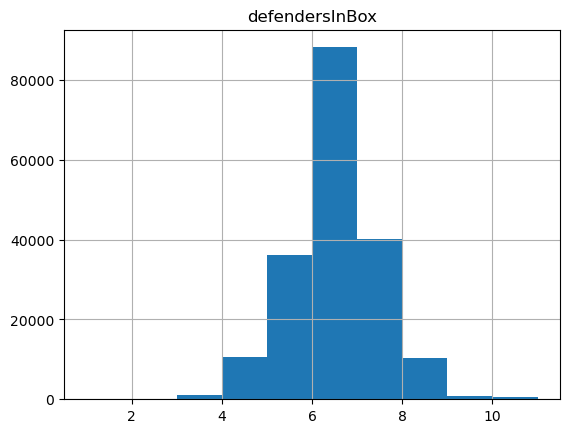

In [146]:
# Let's look at the distribution of the quantitative metric defendersInBox:

data_united[DU_use_int_feats].hist()

In [148]:
data_united[['pff_passCoverage']+DU_use_int_feats].groupby(['pff_passCoverage']).agg(np.median).reset_index()

,pff_passCoverage,defendersInBox
0,2-Man,6.0
1,Cover-0,7.0
2,Cover-1,6.0
3,Cover-2,6.0
4,Cover-3,6.0
5,Cover-6,6.0
6,OTHER,5.5
7,Quarters,6.0
8,Red Zone,6.0


We see that the defensive team uses 6 defenders in close proximity to the line of scrimmage most often.

This method is most often used in scheme of defense:  

Cover-0; Cover-1; Cover-2; Cover-3; Cover-6; Quarters; Red Zone; Goal Line;


## Now let's check in more detail the influence of individual factors on the effectiveness of the protection scheme:

In [149]:
# For example, the ratio of the target metric with categorical features:

data_united[['pff_passCoverage'] + DU_use_cat_feats]

,pff_passCoverage,passResult,offenseFormation,passResult,pff_playAction,pff_passCoverageType,pff_hit,pff_hurry,pff_sack
0,Cover-1,I,SHOTGUN,I,0,Man,-1.0,-1.0,-1.0
1,Cover-1,I,SHOTGUN,I,0,Man,-1.0,-1.0,-1.0
2,Cover-1,I,SHOTGUN,I,0,Man,-1.0,-1.0,-1.0
3,Cover-1,I,SHOTGUN,I,0,Man,-1.0,-1.0,-1.0
4,Cover-1,I,SHOTGUN,I,0,Man,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...
188249,Quarters,S,SHOTGUN,S,0,Zone,-1.0,-1.0,-1.0
188250,Quarters,S,SHOTGUN,S,0,Zone,0.0,0.0,0.0
188251,Quarters,S,SHOTGUN,S,0,Zone,-1.0,-1.0,-1.0
188252,Quarters,S,SHOTGUN,S,0,Zone,0.0,0.0,0.0


In [71]:
data_united['passResult'].value_counts()

C     101640
I      60610
S      11946
R       9878
IN      4180
Name: passResult, dtype: int64

In the important attribute 'passResult' we see the distribution of values: 
C - 101640 -  Complete pass  
I - 60610 - Incomplete pass 
S - 11946 - Quarterback sack  
R - 9878 - Scramble  
IN - 4180 - Intercepted pass  

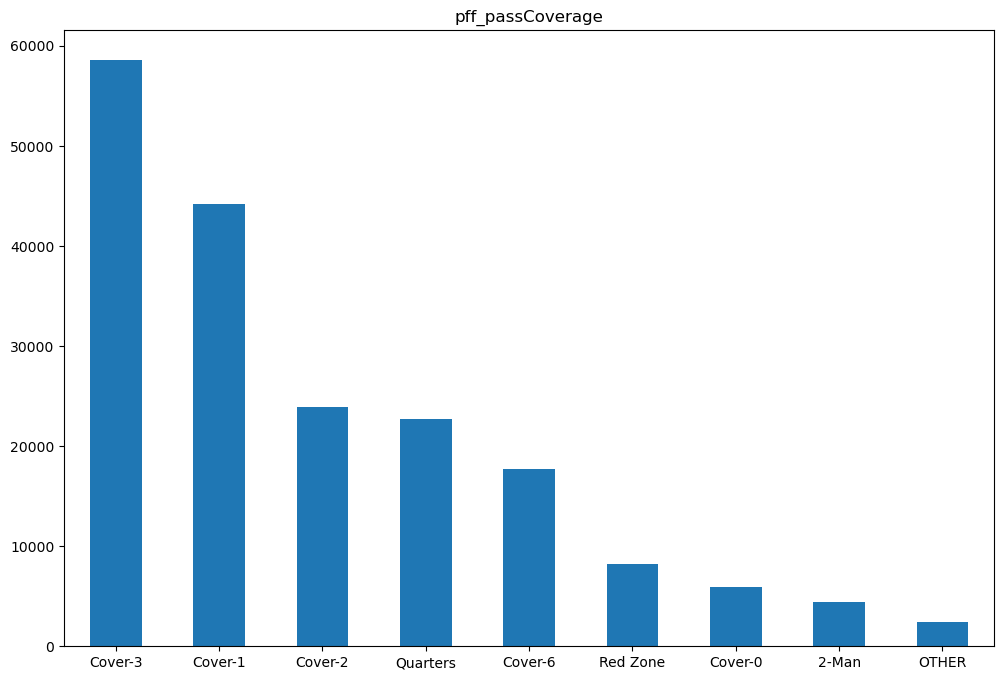

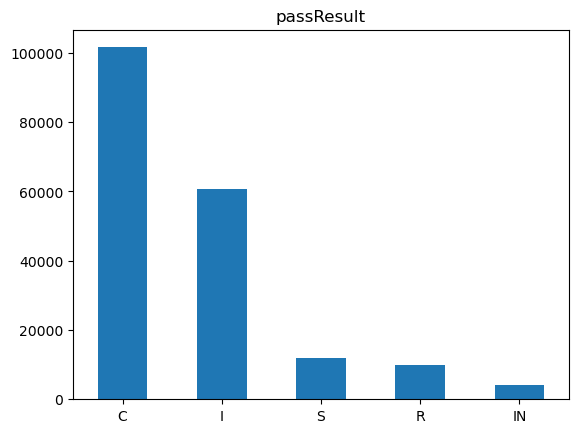

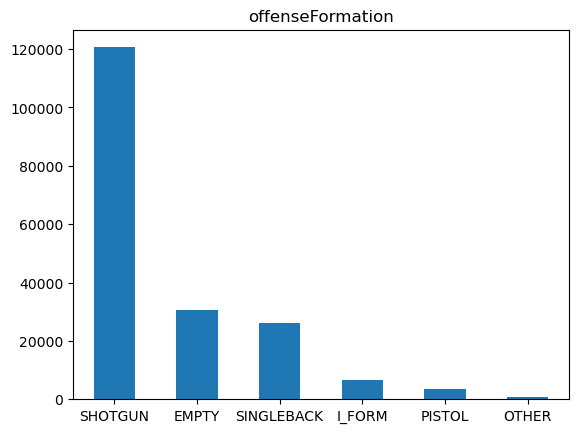

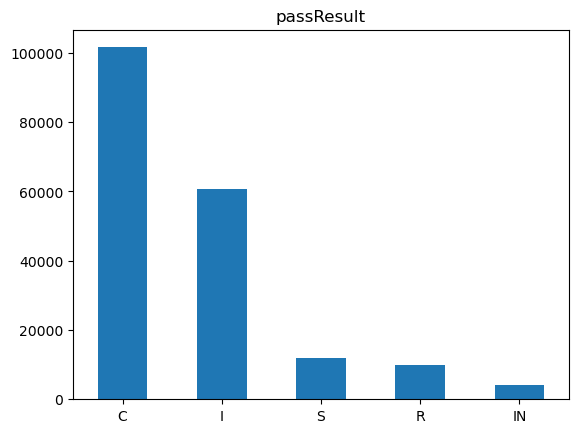

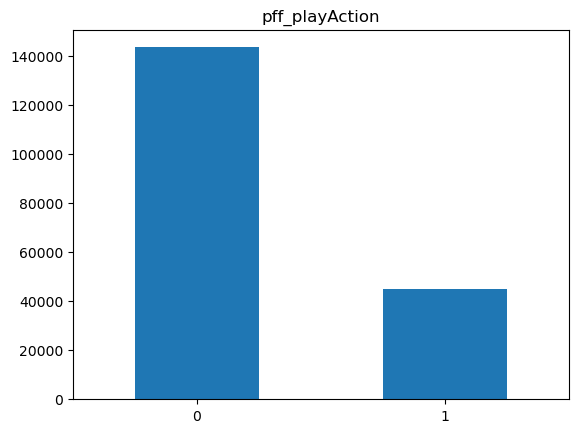

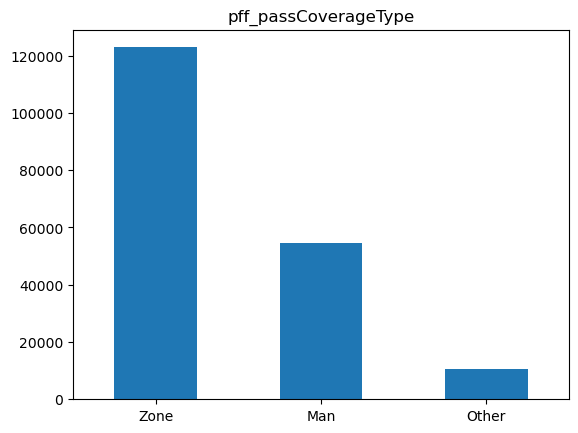

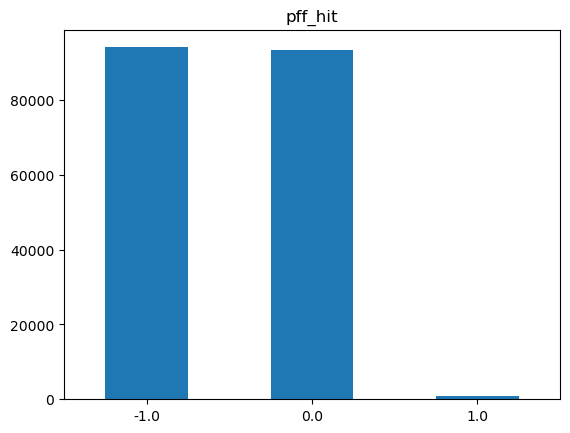

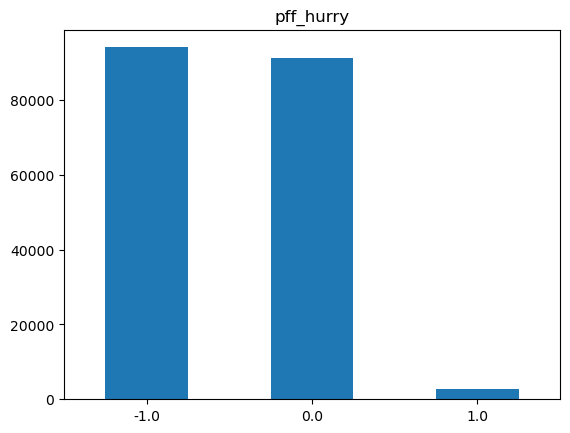

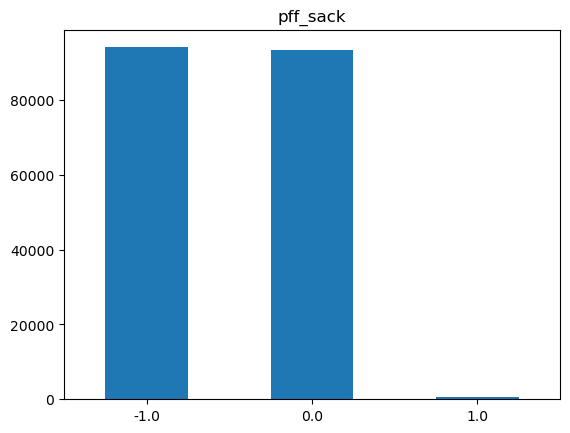

In [72]:
# Let's study the distribution of all categorical features:

figure,ax = plt.subplots(figsize=(12,8))
for item in ['pff_passCoverage']+DU_use_cat_feats:
    ax = plt.subplot()
    ax.set_title(item)
    data_united[item].value_counts().plot.bar(rot=0)
    plt.show()

Here we see that:

'pff_passCoverage' - the most popular scheme of defense is: Cover -3 followed by Cover - 1, after
Cover - 2, Quartes, Cover - 6 schemes are used but not so often. Red Zone, Cover - 0, 2-Man schemes and others are the least popular. 

It is worth noting that Cover - 1 is considered the most aggressive strategy, and Cover - 3 is the most energy-consuming for both defense and attack. It is probably the strategic uniqueness that makes them as effective and semi-popular as possible.


* 'passResult' - the graph also confirms that C (completed pass) is the most frequent value in the 2021 season totals, which positively characterizes the choice of scheme of defense

* 'offenseFormation' - This metric indicates the formation choice used by the team in possession of the ball. SHOTGUN leader - a formation in which the quarterback is 5 yards from the center

* 'playAction' - indicates that fake action, a move that defenders use in HURRY, is not that popular

* 'passCoverageType' - zonal type of protection is in the lead. It includes protection schemes: Cover - 1; cover - 2; cover - 3; Cover - 6 and Cover - 0

* Reception Hit - used in defense infrequently
* Reception Hurry - used in defense infrequently
* Reception Sack - used in defense infrequently

In [73]:
DU_dummies = pd.get_dummies(data_united[DU_use_cat_feats])
DU_dummies['defendersInBox'] = data_united['defendersInBox']
DU_dummies['pff_passCoverage'] = data_united['pff_passCoverage']
DU_dummies_grp = DU_dummies.groupby(['pff_passCoverage']).agg(np.mean).reset_index()

In [74]:
DU_dummies_grp

,pff_passCoverage,passResult_C,passResult_I,passResult_IN,passResult_R,passResult_S,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_OTHER,offenseFormation_PISTOL,...,pff_hit_-1.0,pff_hit_0.0,pff_hit_1.0,pff_hurry_-1.0,pff_hurry_0.0,pff_hurry_1.0,pff_sack_-1.0,pff_sack_0.0,pff_sack_1.0,defendersInBox
0,2-Man,0.455000,0.330000,0.020000,0.100000,0.095000,0.115000,0.010000,0.005000,0.000000,...,0.5,0.494091,0.005909,0.5,0.485227,0.014773,0.5,0.495455,0.004545,5.540112
1,Cover-0,0.477778,0.429630,0.018519,0.029630,0.044444,0.200000,0.025926,0.007407,0.029630,...,0.5,0.492761,0.007239,0.5,0.479125,0.020875,0.5,0.497811,0.002189,6.829630
2,Cover-1,0.464943,0.393834,0.017404,0.046743,0.077076,0.164097,0.029339,0.003978,0.010443,...,0.5,0.495027,0.004973,0.5,0.483635,0.016365,0.5,0.496022,0.003978,6.088049
3,Cover-2,0.600000,0.270968,0.024885,0.044240,0.059908,0.151152,0.036866,0.000922,0.017512,...,0.5,0.495978,0.004022,0.5,0.485589,0.014411,0.5,0.497109,0.002891,5.803687
4,Cover-3,0.586116,0.284053,0.019887,0.049906,0.060038,0.144841,0.047280,0.001501,0.024015,...,0.5,0.495787,0.004213,0.5,0.485622,0.014378,0.5,0.496913,0.003087,6.144474
5,Cover-6,0.580124,0.285714,0.029814,0.052174,0.052174,0.147826,0.033540,0.000000,0.014907,...,0.5,0.495991,0.004009,0.5,0.486618,0.013382,0.5,0.497459,0.002541,5.823602
6,OTHER,0.437500,0.348214,0.071429,0.071429,0.071429,0.160714,0.026786,0.151786,0.000000,...,0.5,0.497565,0.002435,0.5,0.482143,0.017857,0.5,0.497159,0.002841,5.919842
7,Quarters,0.551791,0.304937,0.023233,0.066796,0.053243,0.217812,0.022265,0.002904,0.018393,...,0.5,0.495600,0.004400,0.5,0.485039,0.014961,0.5,0.497316,0.002684,5.750264
8,Red Zone,0.441489,0.388298,0.026596,0.071809,0.071809,0.204787,0.029255,0.007979,0.029255,...,0.5,0.495890,0.004110,0.5,0.481141,0.018859,0.5,0.496373,0.003627,6.316489


This table shows what exactly and how much influences the effectiveness of the scheme of defense, for example:

- Cover-3 is most influenced by:
* passResult_C - that is, a completed pass;
* pff_hit_0.0; pff_hurry_0.0; pff_sack_0.0 - no defensive violations from defender
* defendersInBox - number of defenders in the line of scrimmage > 6

## Let's train the model to predict the effectiveness of the scheme of defense based on the available factors

To do this, prepare the data

In [75]:
#est.fit_transform(data_united[['defendersInBox']]).toarray()

In [76]:
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

for col in ['defendersInBox']:
    data_united[col] = est.fit_transform(data_united[[col]])

In [77]:
DU_dummies= DU_dummies.drop(columns=['defendersInBox'])

In [78]:
DU_dummies_def = pd.get_dummies(data_united['defendersInBox'])
DU_dummies_def.columns=[str(int(col)) +'_defendersInBox' for col in DU_dummies_def.columns]
DU_dummies_results = pd.concat([DU_dummies,DU_dummies_def],axis=1)
DU_dummies_results.head(4)

,passResult_C,passResult_I,passResult_IN,passResult_R,passResult_S,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_OTHER,offenseFormation_PISTOL,offenseFormation_SHOTGUN,...,pff_hurry_0.0,pff_hurry_1.0,pff_sack_-1.0,pff_sack_0.0,pff_sack_1.0,pff_passCoverage,0_defendersInBox,1_defendersInBox,2_defendersInBox,3_defendersInBox
0,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,Cover-1,0,0,1,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,Cover-1,0,0,1,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,Cover-1,0,0,1,0
3,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,Cover-1,0,0,1,0


In [79]:
df_train, df_test = train_test_split(DU_dummies_results, test_size = 0.25)

In [80]:
target_train = df_train.pff_passCoverage.values
features_train = df_train.drop(columns = ['pff_passCoverage'])

target_test = df_test.pff_passCoverage.values
features_test = df_test.drop(columns = ['pff_passCoverage'])

model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model.fit(features_train, target_train) 

LogisticRegression(max_iter=1000, random_state=12345)

# Look at how protection schemes react to game elements

In [81]:
# model.coef_[0]
feats = pd.DataFrame(model.coef_.T)
feats['feat'] = features_train.columns
feats.columns =np.concatenate([ model.classes_,['feat']])
feats.sort_values(by=['Cover-3'], ascending= False)
feats

,2-Man,Cover-0,Cover-1,Cover-2,Cover-3,Cover-6,OTHER,Quarters,Red Zone,feat
0,-0.148250,0.050925,0.014288,0.084639,0.108993,0.008516,-0.129304,0.021186,-0.010992,passResult_C
1,-0.142373,0.133262,0.076998,-0.026808,0.041246,-0.065977,-0.085168,0.015316,0.053503,passResult_I
2,-0.089227,0.019742,-0.042282,0.027323,-0.035706,0.066169,0.202231,-0.030839,-0.117412,passResult_IN
3,0.131223,-0.146113,-0.040175,-0.062215,0.013566,-0.042470,-0.036797,0.124913,0.058068,passResult_R
4,0.046468,-0.150651,0.090941,0.054111,0.083608,-0.103243,0.037473,-0.041663,-0.017045,passResult_S
5,-0.577009,0.626910,-0.072827,-0.187090,-0.312814,0.182666,-0.007333,0.225414,0.122084,offenseFormation_EMPTY
6,0.593904,-0.749578,0.110182,0.133601,0.071240,0.401625,0.103055,-0.569212,-0.094816,offenseFormation_I_FORM
7,1.252603,-1.075883,-0.234583,-0.066380,0.414205,-1.644119,1.593267,0.997102,-1.236213,offenseFormation_OTHER
8,-1.912630,1.367664,0.289271,0.080957,0.138047,0.298530,-1.320913,-0.065028,1.124102,offenseFormation_PISTOL
9,0.353407,-0.137932,-0.116889,-0.054052,-0.366740,0.343243,0.391315,-0.094401,-0.317952,offenseFormation_SHOTGUN


In [82]:
pred_model = model.predict(features_test)
accuracy_score(target_test,pred_model)

0.5930222675505694

The accuracy of the model is not as high as we would like - but given the variety of factors in the data, I will take it with confidence

In [83]:
#cm = confusion_matrix(target_test, pred_model)

In [84]:
print(classification_report(target_test, pred_model))


              precision    recall  f1-score   support

       2-Man       0.00      0.00      0.00      1096
     Cover-0       0.92      0.06      0.11      1502
     Cover-1       0.81      1.00      0.90     10967
     Cover-2       0.00      0.00      0.00      5956
     Cover-3       0.48      1.00      0.64     14659
     Cover-6       0.00      0.00      0.00      4548
       OTHER       0.83      0.38      0.52       635
    Quarters       1.00      0.00      0.00      5684
    Red Zone       0.83      0.98      0.90      2017

    accuracy                           0.59     47064
   macro avg       0.54      0.38      0.34     47064
weighted avg       0.53      0.59      0.46     47064



In [85]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=3)

In [86]:
pred_model = model.predict(features_test)
accuracy_score(target_test,pred_model)

0.588985211626721

# The Decision Tree shows what effect on the effectiveness this or that action of defenders can have

In [87]:
model.classes_

array(['2-Man', 'Cover-0', 'Cover-1', 'Cover-2', 'Cover-3', 'Cover-6',
       'OTHER', 'Quarters', 'Red Zone'], dtype=object)

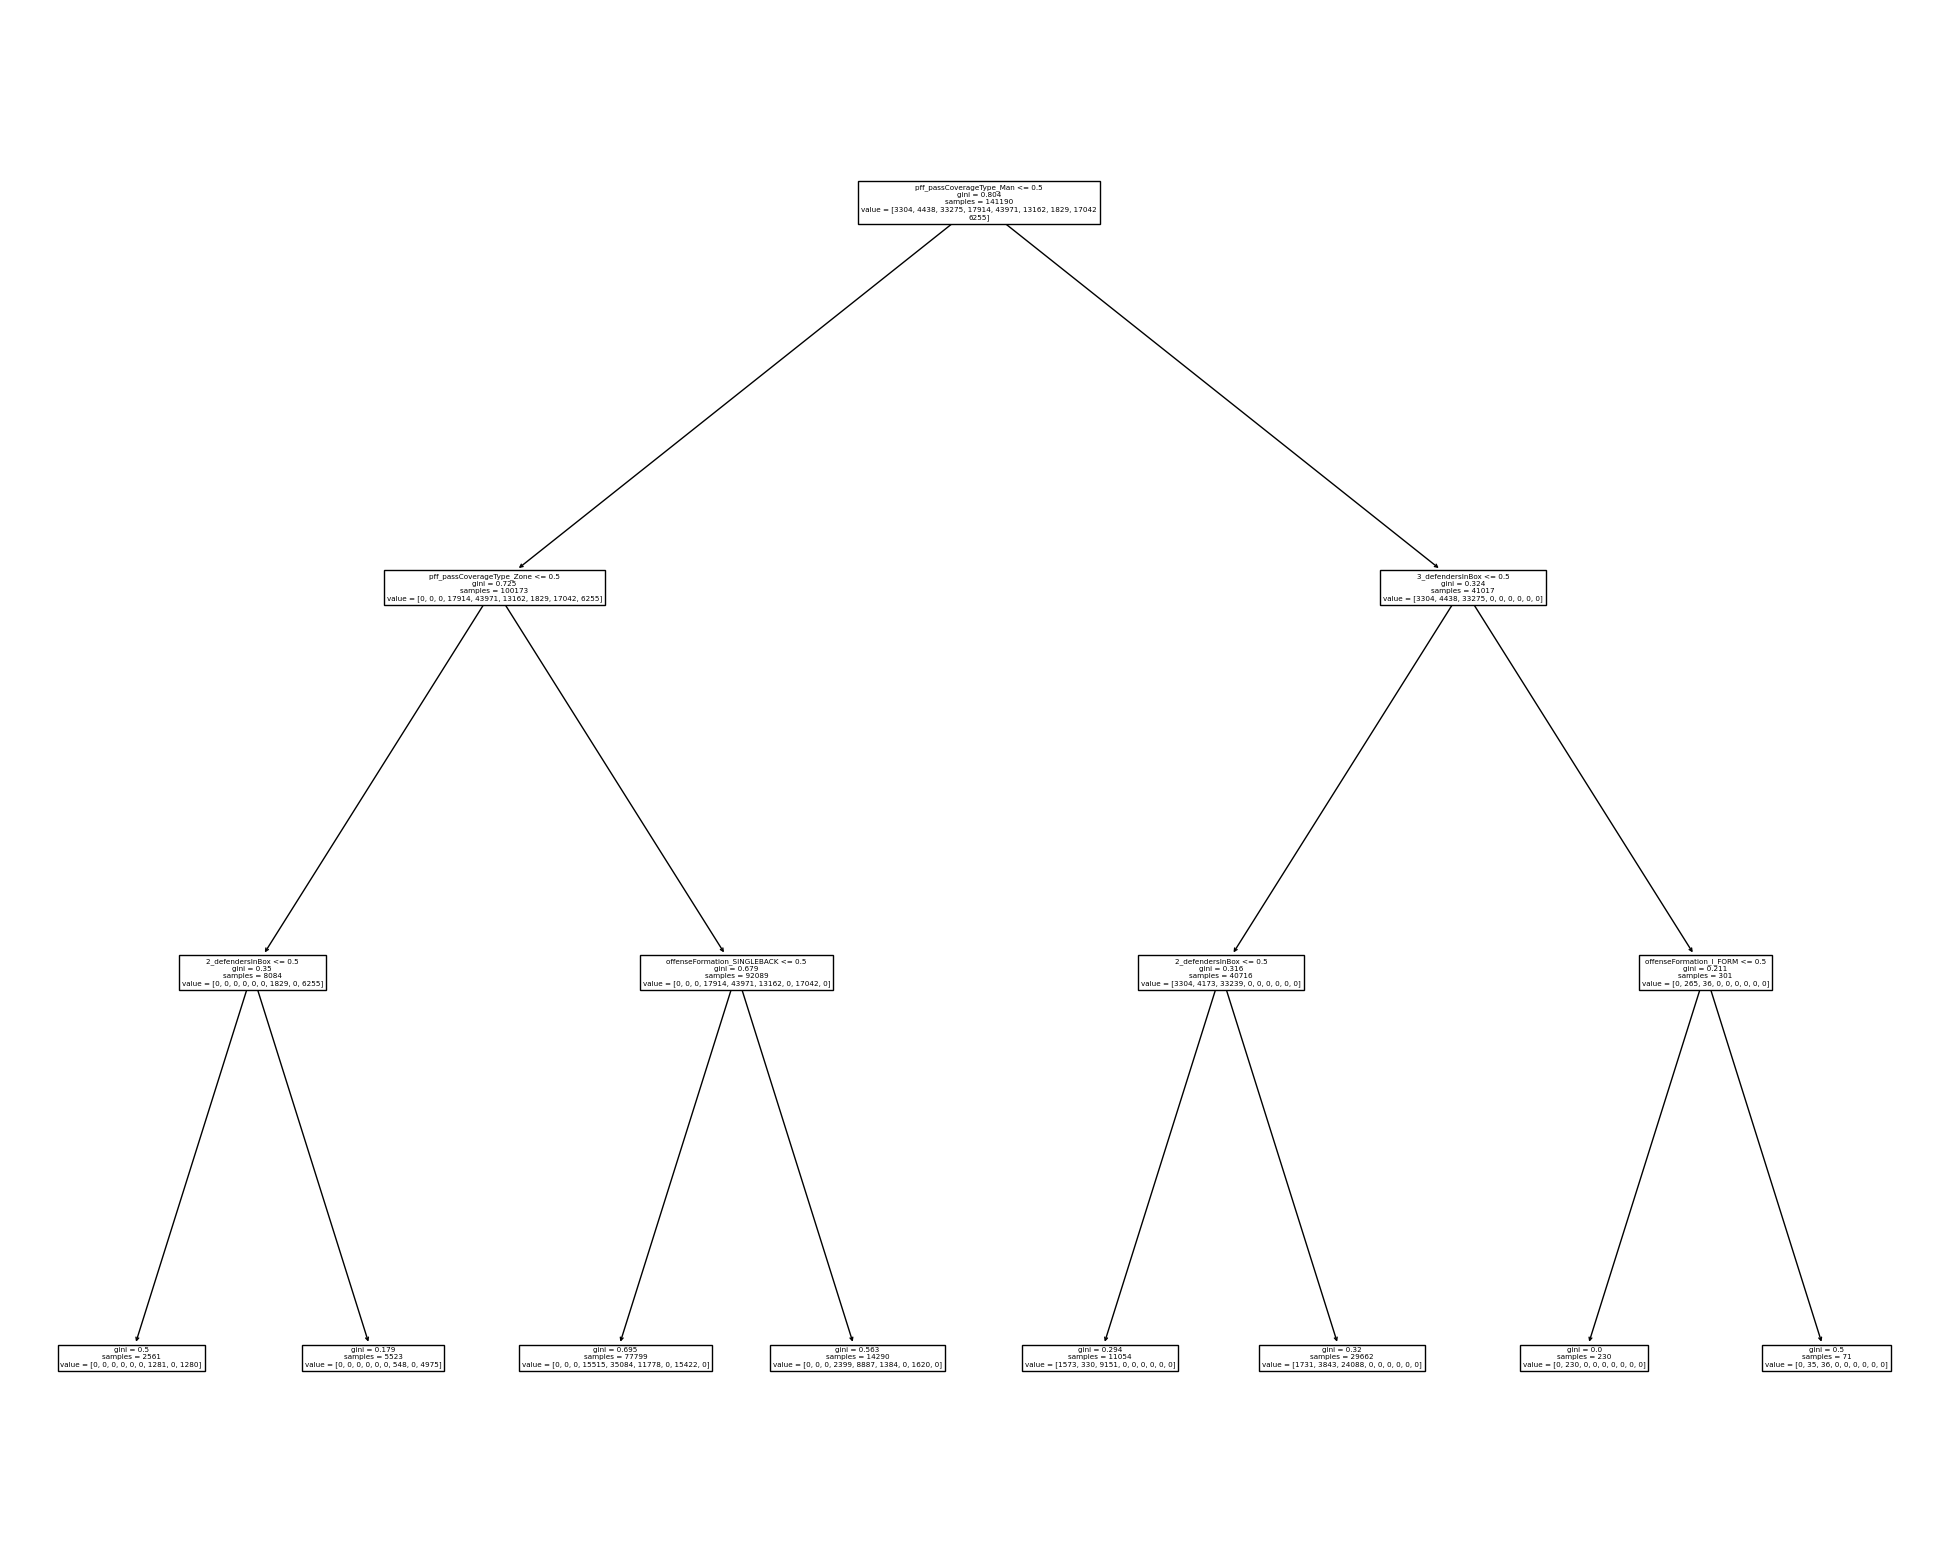

In [88]:
plt.figure(1, figsize=(25, 20))
tree.plot_tree(model,feature_names =features_train.columns)
print()

In [89]:
print(classification_report(target_test, pred_model))


              precision    recall  f1-score   support

       2-Man       0.00      0.00      0.00      1096
     Cover-0       1.00      0.05      0.10      1502
     Cover-1       0.81      1.00      0.90     10967
     Cover-2       0.00      0.00      0.00      5956
     Cover-3       0.48      1.00      0.64     14659
     Cover-6       0.00      0.00      0.00      4548
       OTHER       0.50      0.72      0.59       635
    Quarters       0.00      0.00      0.00      5684
    Red Zone       0.90      0.77      0.83      2017

    accuracy                           0.59     47064
   macro avg       0.41      0.39      0.34     47064
weighted avg       0.41      0.59      0.46     47064



## Conclusion

According to the data for the 2021 season, the choice of coaches was to use the game schemes:

Cover-3 and Cover-1

Much less frequently:

Cover - 2, Quartes, Cover - 6

Both schemes are complex, for example Cover - 1 is considered the most aggressive strategy and Cover - 3 is the most energy-consuming for both defense and attack.

So, I paid attention to the details of the game that influence these schemes, in particular from the side of the defenders. The most significant details of the game for Cover - 3 and Cover -1 were:

'passResult' - the graph also confirms that C (completed pass) is the most frequent value in the 2021 season totals, which positively characterizes the choice of defense strategy

'passCoverageType' - zonal type of protection is in the lead. It includes protection schemes: Cover - 3

Cover-3 and Cover-1 are most influenced by:

passResult_C - that is, a completed pass;
pff_hit_0.0; pff_hurry_0.0; pff_sack_0.0 - no defensive violations from defender
defendersInBox - number of defenders in the line of scrimmage > 6